# Malware classification system - Cirillo & Straziota

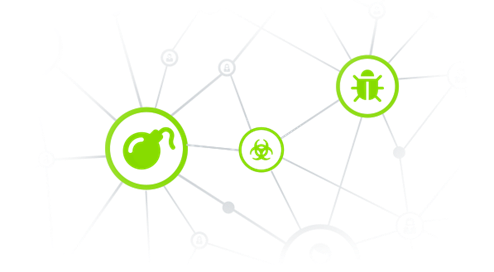

In [46]:
import pandas as pd
import os
import numpy as np
from pprint import pprint
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import svm


# Introduzione

[INTRO]

Nella prossima cella, carichiamo il dataset da una collezione di file `CSV` che contengono, rispettivamente, traffico di rete di applicazioni legalmente scaricate da play store e applicazioni scaricate invece da fonti alternative che corrispondo a malware, in particolare a 
- [Ransomware](#ransomware)
- [Adware](#adware)
- [Scareware](#scareware)
- [SMSmalware](#smsmalware)

## Ransomware
<img src="img/ransomware.webp" style="width: 50%; display:block">

Il [ransomware](https://www.garanteprivacy.it/temi/cybersecurity/ransomware) è un programma informatico dannoso ("malevolo") che può “infettare” un dispositivo digitale (PC, tablet, smartphone, smart TV), bloccando l’accesso a tutti o ad alcuni dei suoi contenuti (foto, video, file, ecc.) per poi chiedere un riscatto (in inglese, “ransom”) da pagare per “liberarli”.

La richiesta di pagamento, con le relative istruzioni, compare di solito in una finestra che si apre automaticamente sullo schermo del dispositivo infettato. All’utente viene minacciosamente comunicato che ha poche ore o pochi giorni per effettuare il versamento del riscatto, altrimenti il blocco dei contenuti diventerà definitivo.

Ci sono due tipi principali di ransomware:
- i cryptor (che criptano i file contenuti nel dispositivo rendendoli inaccessibili);
- i blocker (che bloccano l’accesso al dispositivo infettato).

Ad esempio, nel nostro dataset è presente traffico di rete di un di tipo di ransomware: un trojan mobile, chiamato *Simplocker*:
### Simplocker
<img src="img/simplocker.webp" style="width: 50%; display:block">
Simplocker è un trojan mobile, uno dei primi del suo genere, che si rivolge ai dispositivi mobili Android. Questo malware esegue la scansione della scheda SD residente per determinati tipi di file (.jpeg, .jpg, .png, .bmp, .gif, .pdf, .doc, .docx, .txt, .avi, .mkv, .3gp, .mp4), crittografa questi file utilizzando AES, e poi chiede un riscatto all'utente in cambio della decrittografia di questi file riscattati. Il risultato è che, fino a quando questo riscatto non viene pagato, gli utenti non sono in grado di accedere ai loro file personali (immagini, download, canzoni, ecc.).

## Adware
<img src="img/adware.jpg" style="width: 50%; display:block">
L'Adware è un software indesiderato progettato per lanciare messaggi pubblicitari sullo schermo, spesso all'interno di un browser web. Alcuni professionisti della sicurezza li considerano i precursori del moderno PUP (programma potenzialmente indesiderato). Gli adware si avvalgono in genere di un metodo subdolo, mascherandosi da componenti legittimi o causando il trasferimento su un altro programma al fine di provocarne con l'inganno l'installazione su PC, tablet o dispositivo mobile.

In particolare, come esempio di adware, consideriamo [Mobidash](https://www.malwarebytes.com/blog/detections/android-adware-mobidash):
### MobiDash
<img src="img/MobiDash.png" style="width: 50%; display:block">
Android/Adware.MobiDash è il nome di detection per adware che prende di mira i dispositivi mobili che eseguono il sistema operativo Android. Si presenta sotto forma di un Ad SDK che può essere facilmente aggiunto a qualsiasi APK. Molte volte, un APK legittimo viene preso e riconfezionato con Ad SDK. MobiDash visualizza gli annunci pop-up dopo lo sblocco dello schermo. Una caratteristica unica di MobiDash è che attende circa tre giorni dopo l'installazione per visualizzare gli annunci. MobiDash è diventato prevalente nel 2015 e continua a diffondersi attraverso centinaia di varianti.

Ha utilizzato la popolarità di FaceApp per diffondersi. La società di sicurezza Kaspersky ha scoperto l’adware il 7 luglio quando gli utenti hanno riferito che dopo aver scaricato il virale FaceApp da fonti non ufficiali l’applicazione non si è riuscita a installare. Quando gli utenti installano MobiDash pensando che sia FaceApp, sono portati a credere che l’applicazione non sia stata installata. I segni evidenti dell’applicazione installata sul dispositivo scompaiono, ma un modulo dannoso rimane ancora e visualizza silenziosamente pubblicità. Kaspersky ha riferito che almeno 500 dispositivi sono stati infettati entro un periodo di 48 ore a partire dal 19 luglio.

## Scareware
<img src="img/scareware.jpg" style="width: 50%; display:block">
Lo scareware è un tipo di malware che utilizza il social engineering per generare panico o preoccupazioni o per convincere gli utenti che sussiste una minaccia specifica per indurli a installare o acquistare software non richiesti. Questa minaccia è connessa a falsi programmi o software antivirus per la disinfezione e il ripristino.
Nella maggior parte dei casi, il virus menzionato è fittizio e il software consigliato non funziona o installa il vero malware. Gli scareware possono anche essere applicazioni o virus progettati per ingannare gli utenti e causare panico o preoccupazione.

Un esempio di scareware che possiamo trovare nel nostro dataset è [FakeApp](###FakeApp)

### FakeApp
<img src="img/FakeApp.jpeg" style="width: 20%; display: block">
Android/FakeApp si maschera come un'app legittima che afferma di eseguire varie azioni come essere un'app antivirus, un aggiornamento e altre app. La vera intenzione è spesso quella di guadagnare entrate attraverso la visualizzazione di annunci e il reindirizzamento degli utenti per installare altre app, per lo più app legittime tramite Google Play. Tuttavia, le varianti Android/FakeApp sono state viste svolgere attività più dannose come l'invio/ricezione di messaggi SMS e il download/drop di altre app.

## SMSmalware
<img src="img/smsmalware.jpg" style="width: 50%; display:block">
Questi trojan utilizzano i servizi di messaggistica SMS (text) di un dispositivo mobile per inviare e intercettare messaggi. L'utente di solito non è a conoscenza del comportamento.

### FakeNotify
<img src="img/fakenotify.jpg" style="width: 20%; display:block">
Trojan:Android/FakeNotify è un cavallo di Troia per dispositivi Android che si traveste da applicazione che fornisce notifiche di aggiornamento; quando viene eseguita, tuttavia, l'app invia silenziosamente messaggi SMS a numeri premium, raccoglie e invia informazioni e reindirizza quindi l'utente a un sito web non richiesto.

In [48]:
def tryconvert(x, to_type, default):
  '''
  Try convert `x` to a type specified by `to_type` function. 
  Returns `default` value if casting is not possibile 
  '''
  try:
    return to_type(x)
  except:
    return default

def load_data(directory, nrows=None, usecols=None, converters=None, dtype=None):
# Read each CSV file in dir "path/to/root_dir"
    dfs = []
    for file in Path(directory).glob('**/*.csv'):
        dfs.append(pd.read_csv(file, nrows=nrows, converters=converters, dtype=dtype))
    # Put the dataframes to a single dataframe
    df = pd.concat(dfs, ignore_index=True)
    return df

benign_dir = os.path.join(os.getcwd(), 'dataset', 'Benign')
malware_dir = os.path.join(os.getcwd(), 'dataset', 'Malware')

usecols = [" Total Length of Bwd Packets", " Fwd Packet Length Std", " Bwd Packet Length Min", " Bwd Packet Length Std", " Flow IAT Mean", " Flow IAT Min", "Init_Win_bytes_forward", " Init_Win_bytes_backward", " min_seg_size_forward", " Label"]

# Define column datatype when reading CSVs
converters = dict(itertools.product(usecols, [lambda x: tryconvert(x, float, np.nan)]))
converters[" Label"] = lambda x: x

# Load data
N_rows = 1000
benign_df = load_data(benign_dir, nrows=None, usecols=usecols, converters=converters)
malware_df = load_data(malware_dir, nrows=None, usecols=usecols, converters=converters)

df = pd.concat([benign_df, malware_df], ignore_index=True)

# shuffle dataset
#df = df.sample(frac=1).reset_index(drop=True)

# trim columns labels
df.columns = df.columns.str.strip()

# Drop rows which contain NaN values
df.dropna(inplace=True)

# Drop empty label rows
df.drop(df[df["Label"] == ''].index, inplace = True)

# Change Label values in "MALWARE" or "BENIGN"
df["Label"] = df["Label"].apply(lambda x: 'MALWARE' if x != 'BENIGN' else x)
df

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,10.42.0.42-108.174.10.10-45599-80-6,10.42.0.42,45599.0,108.174.10.10,80.0,6.0,22/06/2017 11:19:51,210533.0,3.0,4.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,10.42.0.42-108.174.10.10-45599-80-6,10.42.0.42,45599.0,108.174.10.10,80.0,6.0,22/06/2017 11:19:51,142284.0,2.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,172.217.11.10-10.42.0.42-443-48822-6,10.42.0.42,48822.0,172.217.11.10,443.0,6.0,22/06/2017 11:19:56,37530.0,1.0,2.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,172.217.12.174-10.42.0.42-443-39917-6,10.42.0.42,39917.0,172.217.12.174,443.0,6.0,22/06/2017 11:19:57,36739.0,1.0,2.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,10.42.0.42-52.37.10.236-54948-80-6,10.42.0.42,54948.0,52.37.10.236,80.0,6.0,22/06/2017 11:20:07,289279.0,2.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2616574,10.42.0.151-10.42.0.1-8300-53-17,10.42.0.151,8300.0,10.42.0.1,53.0,17.0,14/06/2017 12:44:29,400167.0,1.0,1.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MALWARE
2616575,172.217.2.174-10.42.0.151-443-44967-6,10.42.0.151,44967.0,172.217.2.174,443.0,6.0,14/06/2017 12:49:41,60072632.0,3.0,1.0,...,32.0,118314.0,0.0,118314.0,118314.0,59932174.0,0.0,59932174.0,59932174.0,MALWARE
2616576,10.42.0.151-31.13.71.37-39170-443-6,31.13.71.37,443.0,10.42.0.151,39170.0,6.0,14/06/2017 12:32:50,6714.0,2.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MALWARE
2616577,10.42.0.151-10.42.0.1-55323-53-17,10.42.0.151,55323.0,10.42.0.1,53.0,17.0,14/06/2017 12:40:44,92288.0,1.0,1.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MALWARE


# Data Information
Di seguito, le informazioni riassuntive della porzione di dataset considerata:

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2616566 entries, 0 to 2616578
Data columns (total 85 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Flow ID                      object 
 1   Source IP                    object 
 2   Source Port                  float64
 3   Destination IP               object 
 4   Destination Port             float64
 5   Protocol                     float64
 6   Timestamp                    object 
 7   Flow Duration                float64
 8   Total Fwd Packets            float64
 9   Total Backward Packets       float64
 10  Total Length of Fwd Packets  float64
 11  Total Length of Bwd Packets  float64
 12  Fwd Packet Length Max        float64
 13  Fwd Packet Length Min        float64
 14  Fwd Packet Length Mean       float64
 15  Fwd Packet Length Std        float64
 16  Bwd Packet Length Max        float64
 17  Bwd Packet Length Min        float64
 18  Bwd Packet Length Mean       float64
 19  

Alcune statistiche utili:

In [5]:
df.describe()

,Total Length of Bwd Packets,Fwd Packet Length Std,Bwd Packet Length Min,Bwd Packet Length Std,Flow IAT Mean,Flow IAT Min,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward
count,2.616568e+06,2.616568e+06,2.616568e+06,2.616568e+06,2.616568e+06,2.616568e+06,2.616568e+06,2.616568e+06,2.616568e+06
mean,1.401781e+04,7.897694e+01,2.437671e+01,1.275733e+02,2.990361e+06,1.844339e+06,2.265293e+04,1.979929e+03,-7.053492e+03
std,3.065368e+05,1.591710e+02,6.843422e+01,2.335095e+02,8.036968e+06,7.386673e+06,3.049101e+04,8.441528e+03,4.542778e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-4.300000e+01,-1.000000e+00,-1.000000e+00,-1.395063e+09
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400200e+04,2.900000e+01,3.300000e+01,-1.000000e+00,2.000000e+01
50%,1.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.718820e+05,4.176000e+03,1.505000e+03,0.000000e+00,3.200000e+01
75%,3.320000e+02,9.481139e+01,0.000000e+00,1.114286e+02,1.876042e+06,1.362130e+05,6.553500e+04,3.520000e+02,3.200000e+01
max,1.503985e+08,4.672402e+03,1.460000e+03,1.335115e+03,1.199725e+08,1.199725e+08,6.553500e+04,6.553500e+04,1.705249e+08


# Data visualization
Di seguito, alcuni plot che mostrano come sono distribuiti i dati:

<AxesSubplot: xlabel='Label', ylabel='# occurrences'>

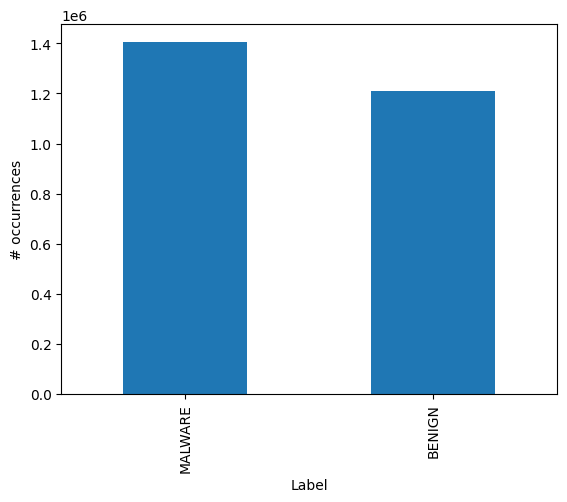

In [6]:
df["Label"].value_counts().plot(
    kind="bar",
    xlabel="Label",
    ylabel="# occurrences"
)

<AxesSubplot: ylabel='Label'>

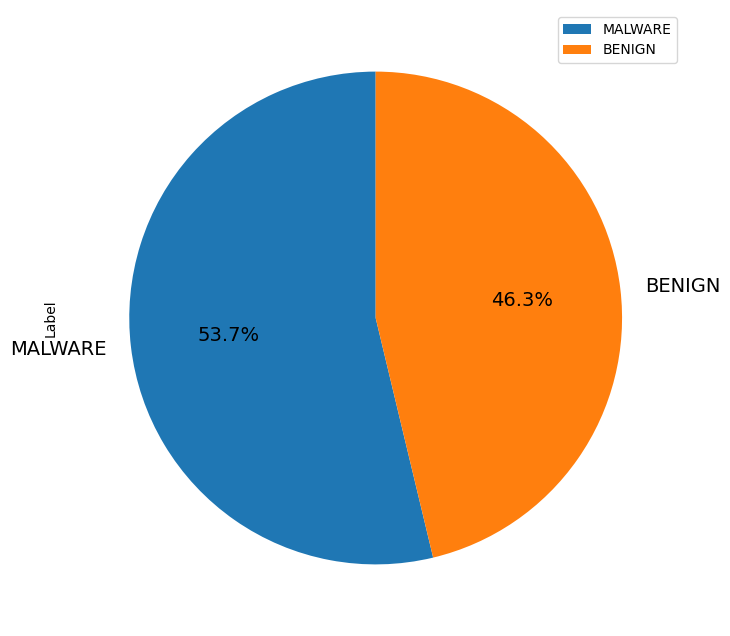

In [7]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

df["Label"].value_counts().plot(
    kind="pie",
    autopct='%1.1f%%',
    startangle=90,
    shadow=False,
    legend=True,
    fontsize=14,
    ax=ax
)

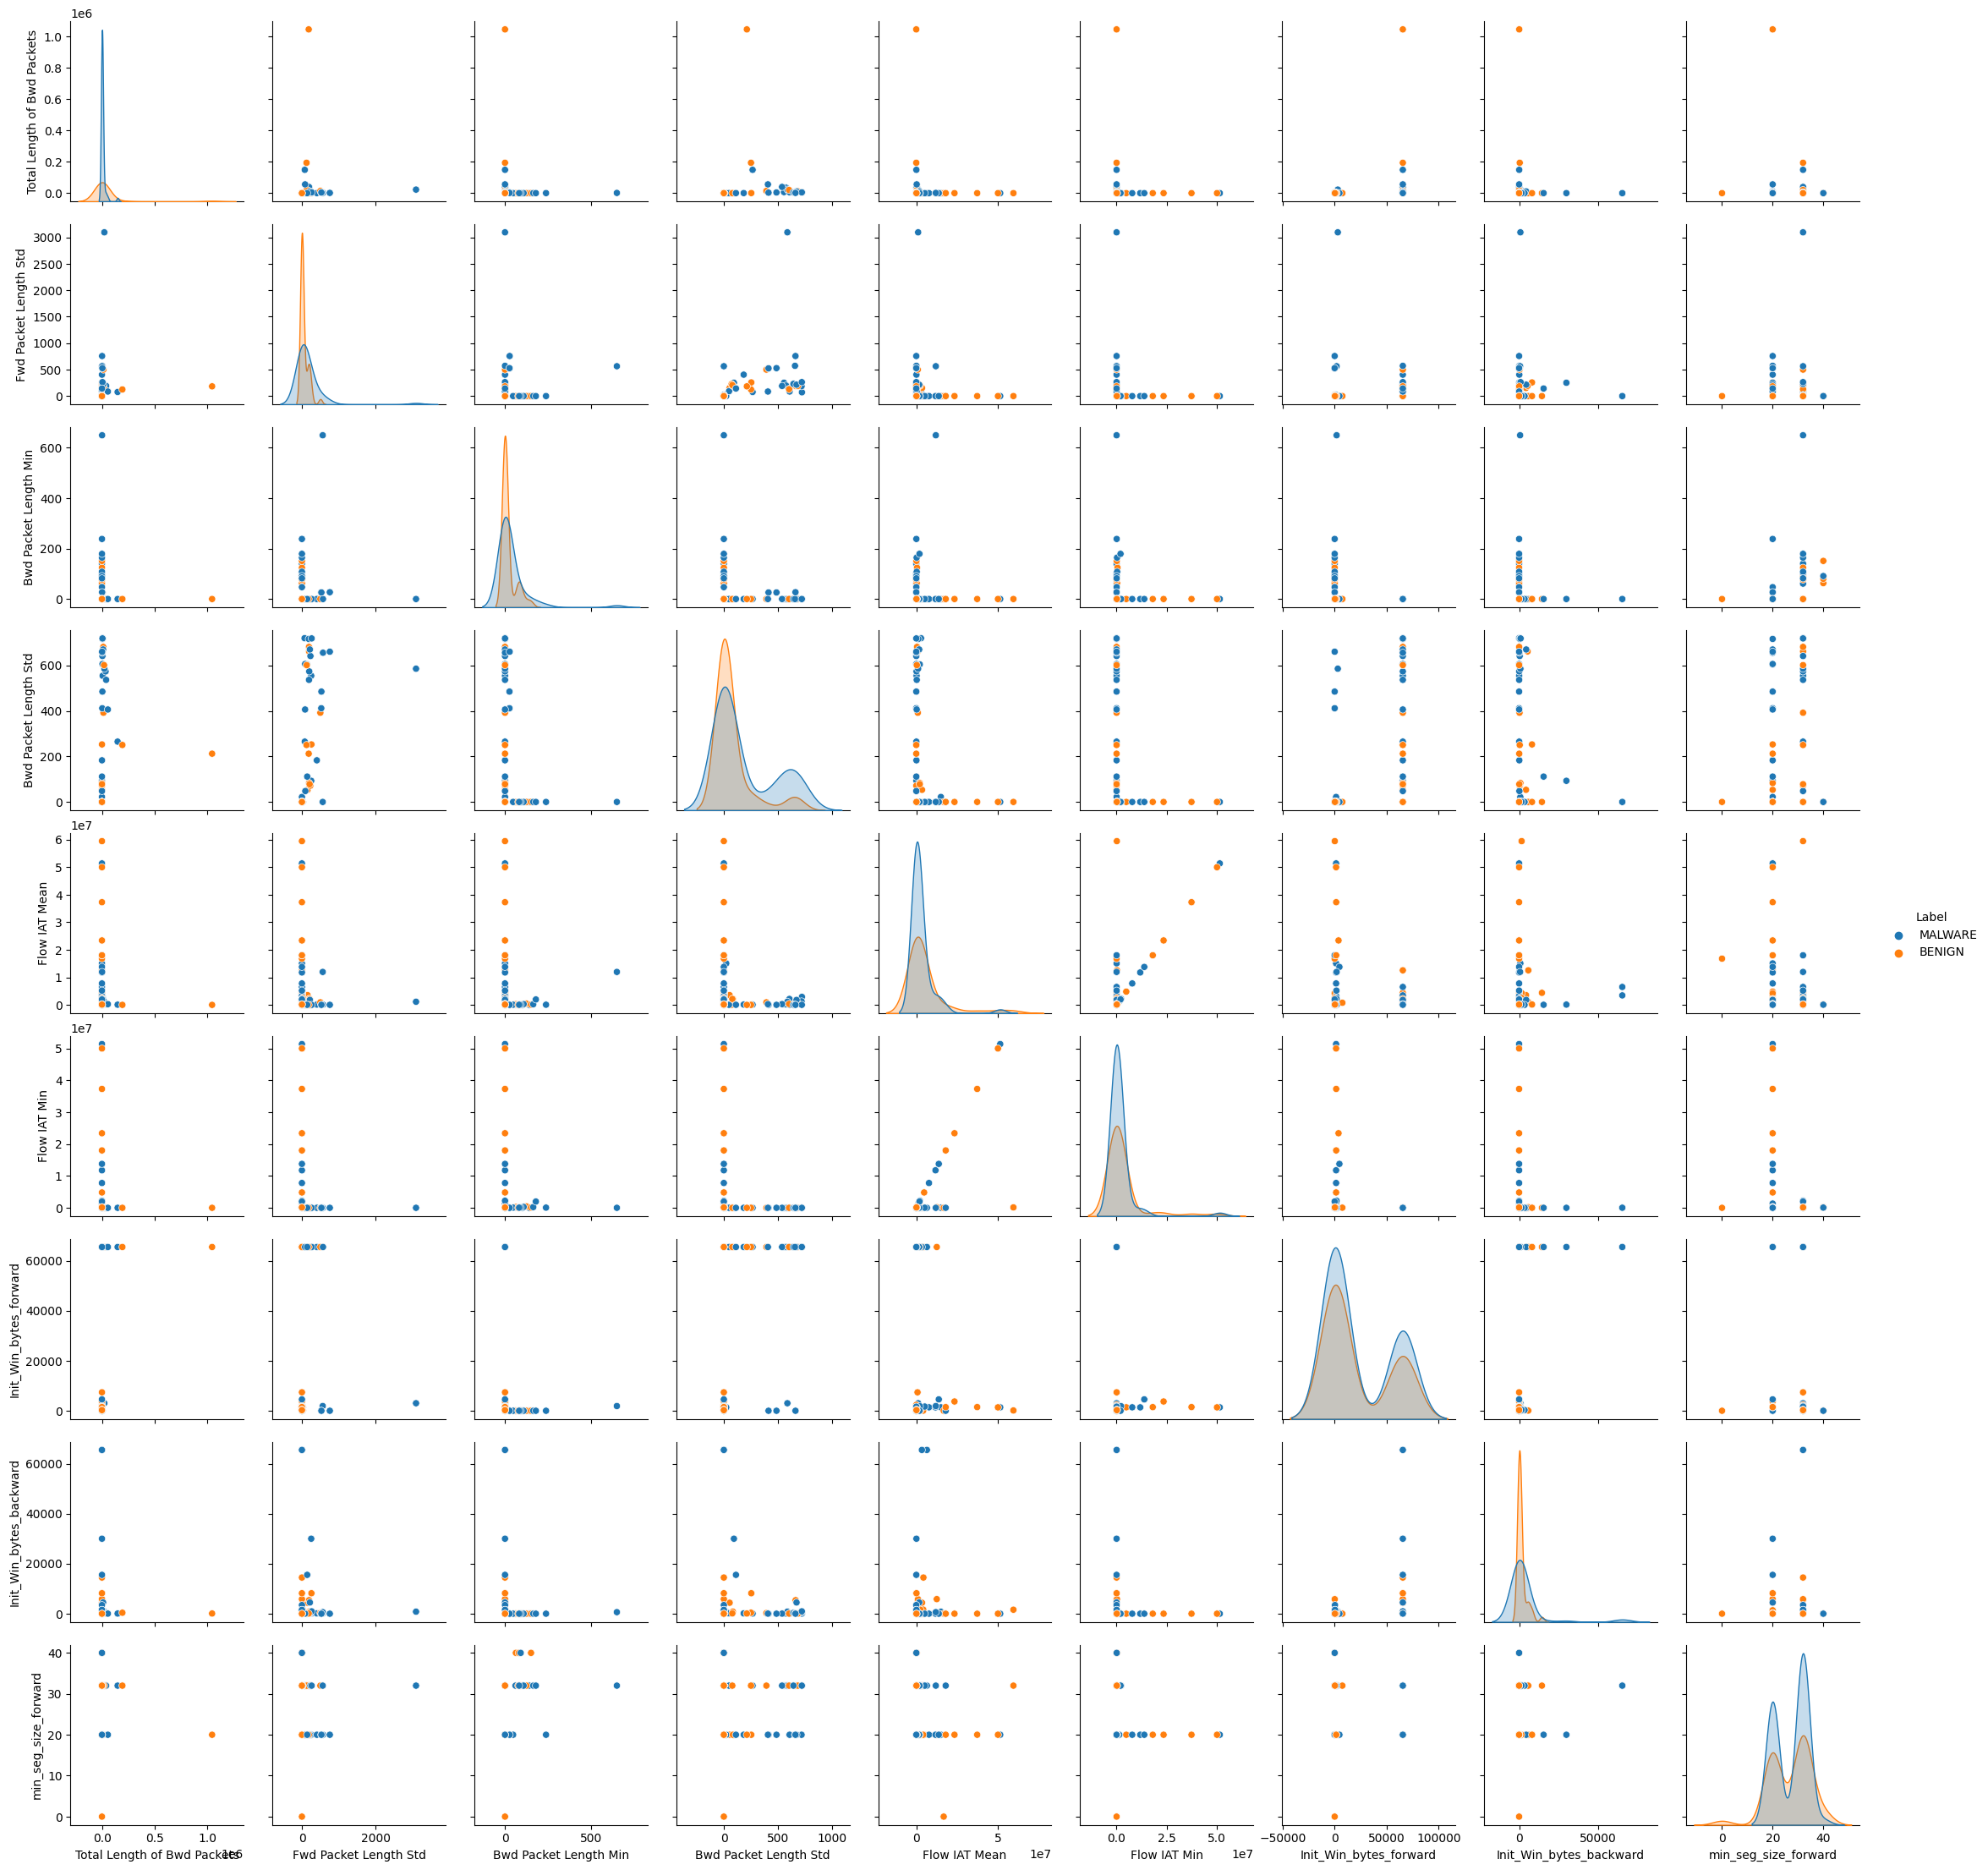

In [8]:
df = df.sample(frac=1).reset_index(drop=True)
sns.pairplot(df.iloc[:100], hue="Label")

# Data Preprocessing
Codifichiamo alcune informazioni non strutturate

In [9]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

def data_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    if "Source IP" in df.columns:
        df['Source IP'] = label_encoder.fit_transform(df['Source IP'])
    if "Flow ID" in df.columns:
        df['Flow ID'] = label_encoder.fit_transform(df['Flow ID'])
    if "Destination IP" in df.columns:
        df['Destination IP'] = label_encoder.fit_transform(df['Destination IP'])

    if "Timestamp" in df.columns:
        # drop column Timestamp
        df = df.drop(['Timestamp'], axis=1)    
    return df

df = data_preprocessing(df)
df.shape

(2616568, 10)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Label'], axis=1),
    df['Label'],
    test_size=0.4,
    random_state=42
)

X_train.shape, X_test.shape

((1569940, 9), (1046628, 9))

In [11]:
X_train.head()

,Total Length of Bwd Packets,Fwd Packet Length Std,Bwd Packet Length Min,Bwd Packet Length Std,Flow IAT Mean,Flow IAT Min,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward
2036222,78.0,0.000000,78.0,0.00000,4.080860e+05,408086.0,-1.0,-1.0,32.0
2546636,0.0,0.000000,0.0,0.00000,1.696370e+06,1696370.0,1685.0,-1.0,20.0
100387,2257.0,515.539154,27.0,496.45585,1.179232e+06,4.0,-1.0,-1.0,20.0
474896,9738.0,292.579367,0.0,634.68426,1.000110e+06,20.0,65535.0,188.0,20.0
1322897,0.0,0.000000,0.0,0.00000,4.367500e+03,1550.0,1641.0,-1.0,32.0


In [12]:
y_train.head()

2036222    MALWARE
2546636     BENIGN
100387     MALWARE
474896      BENIGN
1322897    MALWARE
Name: Label, dtype: object

# Valutazione
Di seguito, una funzione per valutare le performance di un modello ed una funzione per stampare la relativa matrice di confusione

In [13]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label'
    )
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha='right',
        rotation_mode='anchor'
    )
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    return ax

def valuate(clf, x_test, y_test):
    y_pred = clf.predict(x_test)
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, classes=clf.classes_, title='Confusion matrix')


# Decision Tree

In [14]:
from sklearn import tree
decision_tree = tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train, y_train)

[Text(0.5, 0.875, 'Flow IAT Min <= 2.5\ngini = 0.497\nsamples = 1569940\nvalue = [726221, 843719]\nclass = MALWARE'),
 Text(0.25, 0.625, 'Flow IAT Mean <= 23908.165\ngini = 0.454\nsamples = 51172\nvalue = [17845, 33327]\nclass = MALWARE'),
 Text(0.125, 0.375, 'Total Length of Bwd Packets <= 275692.5\ngini = 0.494\nsamples = 17055\nvalue = [7564, 9491]\nclass = MALWARE'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'Bwd Packet Length Std <= 108.636\ngini = 0.421\nsamples = 34117\nvalue = [10281, 23836]\nclass = MALWARE'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'Total Length of Bwd Packets <= 5488.5\ngini = 0.498\nsamples = 1518768\nvalue = [708376, 810392]\nclass = MALWARE'),
 Text(0.625, 0.375, 'Init_Win_bytes_forward <= 16394.0\ngini = 0.497\nsamples = 1379976\nvalue = [634474, 745502]\nclass = MALWARE'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)

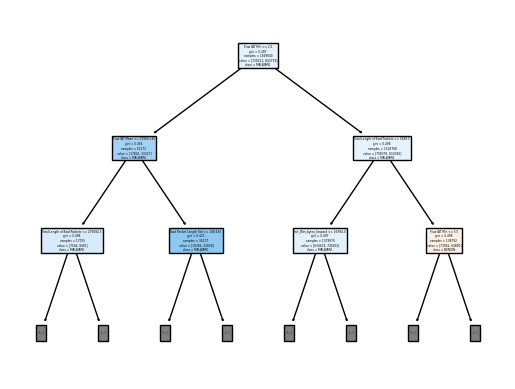

In [15]:
tree.plot_tree(decision_tree, filled=True, class_names=decision_tree.classes_, feature_names=X_train.columns, max_depth=2)

              precision    recall  f1-score   support

      BENIGN       0.60      0.59      0.60    483989
     MALWARE       0.65      0.66      0.66    562639

    accuracy                           0.63   1046628
   macro avg       0.63      0.63      0.63   1046628
weighted avg       0.63      0.63      0.63   1046628



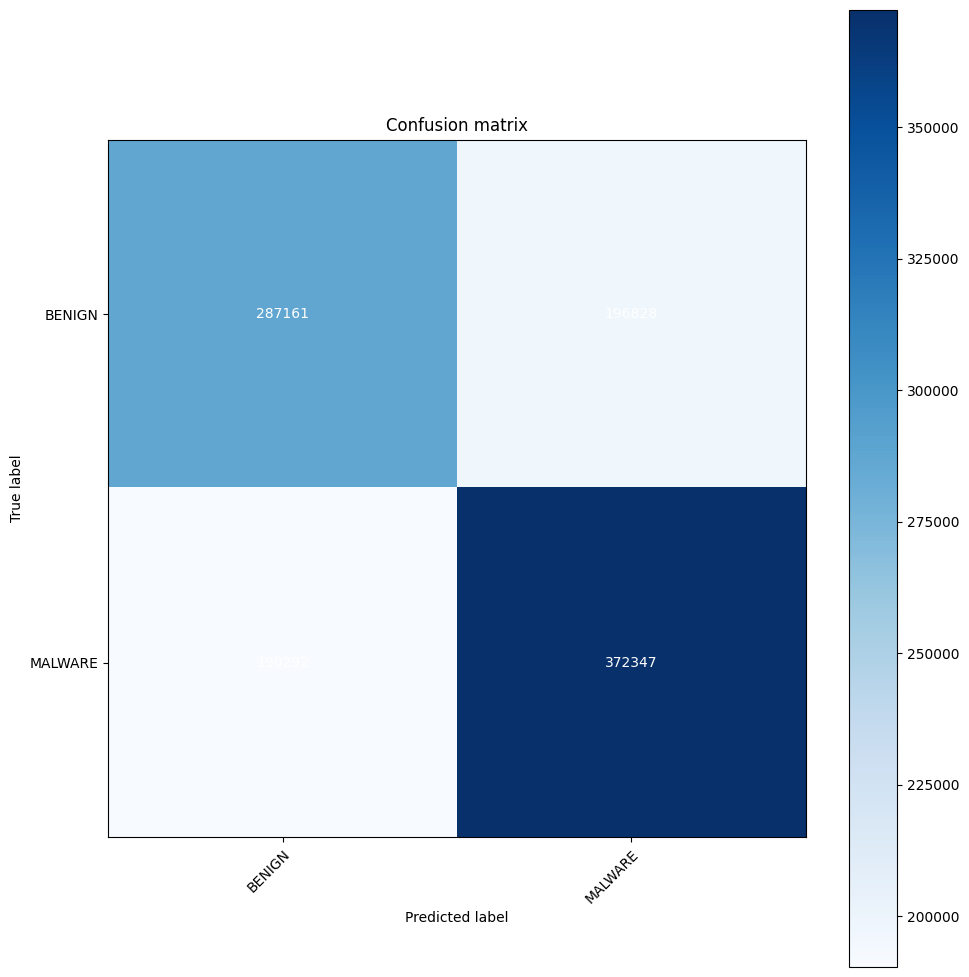

In [16]:
valuate(decision_tree, X_test, y_test)

In [17]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    decision_tree,
    X_train,
    y_train,
    cv=10,
    scoring=['precision_macro', 'recall_macro']
)

In [21]:
print(f'{10}-fold cross validation:')
print('Precision: %0.2f (+/- %0.2f)' % (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std() * 2))
print('Recall: %0.2f (+/- %0.2f)' % (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std() * 2))

10-fold cross validation:
Precision: 0.62 (+/- 0.00)
Recall: 0.62 (+/- 0.00)


# KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

              precision    recall  f1-score   support

      BENIGN       0.56      0.53      0.54      4654
     MALWARE       0.61      0.63      0.62      5346

    accuracy                           0.58     10000
   macro avg       0.58      0.58      0.58     10000
weighted avg       0.58      0.58      0.58     10000



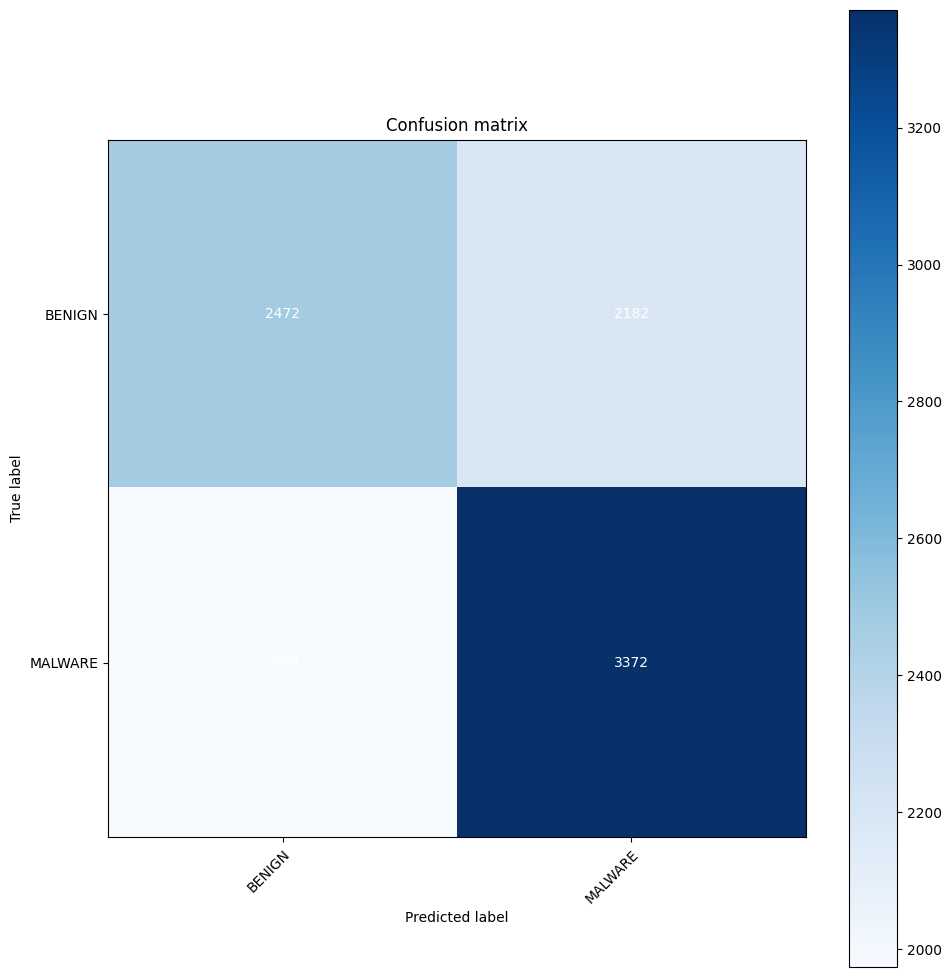

In [27]:
valuate(knn, X_test[:10_000], y_test[:10_000])

# Support Vector Machine

In [30]:
C=1.0
models = (
    # svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=100, dual=True),
    svm.SVC(kernel="rbf", gamma=0.7, C=C, max_iter=100),
    #svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
)
models = [clf.fit(X_train, y_train) for clf in models]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


LinearSVC:
              precision    recall  f1-score   support

      BENIGN       0.43      0.37      0.40    483989
     MALWARE       0.51      0.57      0.54    562639

    accuracy                           0.48   1046628
   macro avg       0.47      0.47      0.47   1046628
weighted avg       0.47      0.48      0.47   1046628

SVC:
              precision    recall  f1-score   support

      BENIGN       0.46      1.00      0.63    483989
     MALWARE       0.37      0.00      0.00    562639

    accuracy                           0.46   1046628
   macro avg       0.42      0.50      0.32   1046628
weighted avg       0.41      0.46      0.29   1046628



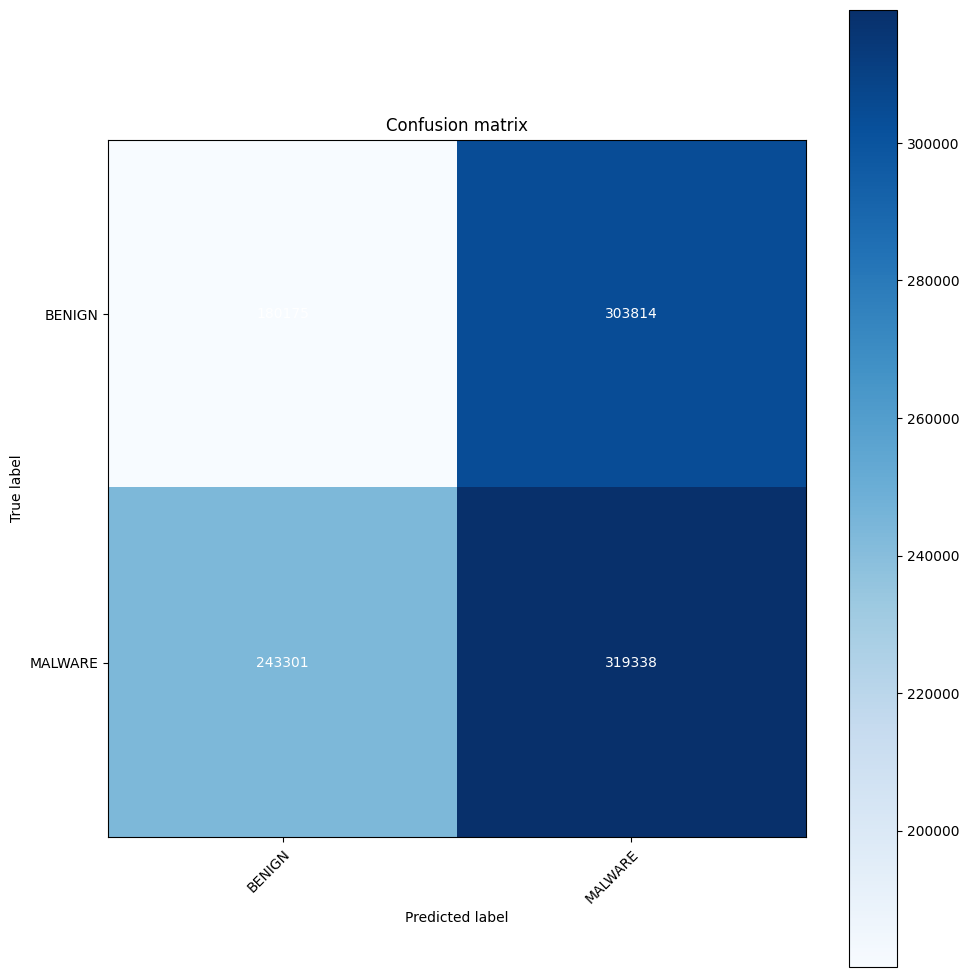

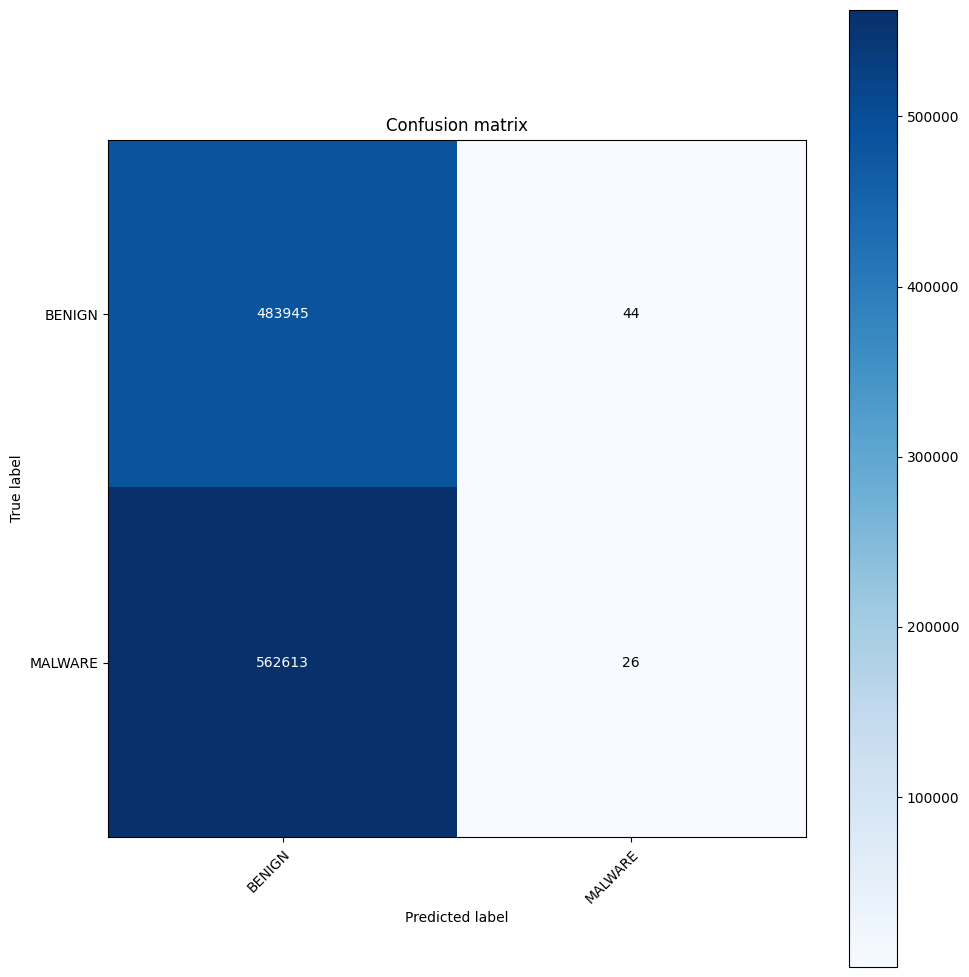

In [31]:
# valuate models

for clf in models:
    # print scores 
    print(f'{clf.__class__.__name__}:')
    valuate(clf, X_test, y_test)

# Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression

logistic_classifier = LogisticRegression(random_state=0, max_iter=100).fit(X_train, y_train)

              precision    recall  f1-score   support

      BENIGN       0.33      0.01      0.01    483989
     MALWARE       0.54      0.99      0.70    562639

    accuracy                           0.53   1046628
   macro avg       0.43      0.50      0.35   1046628
weighted avg       0.44      0.53      0.38   1046628



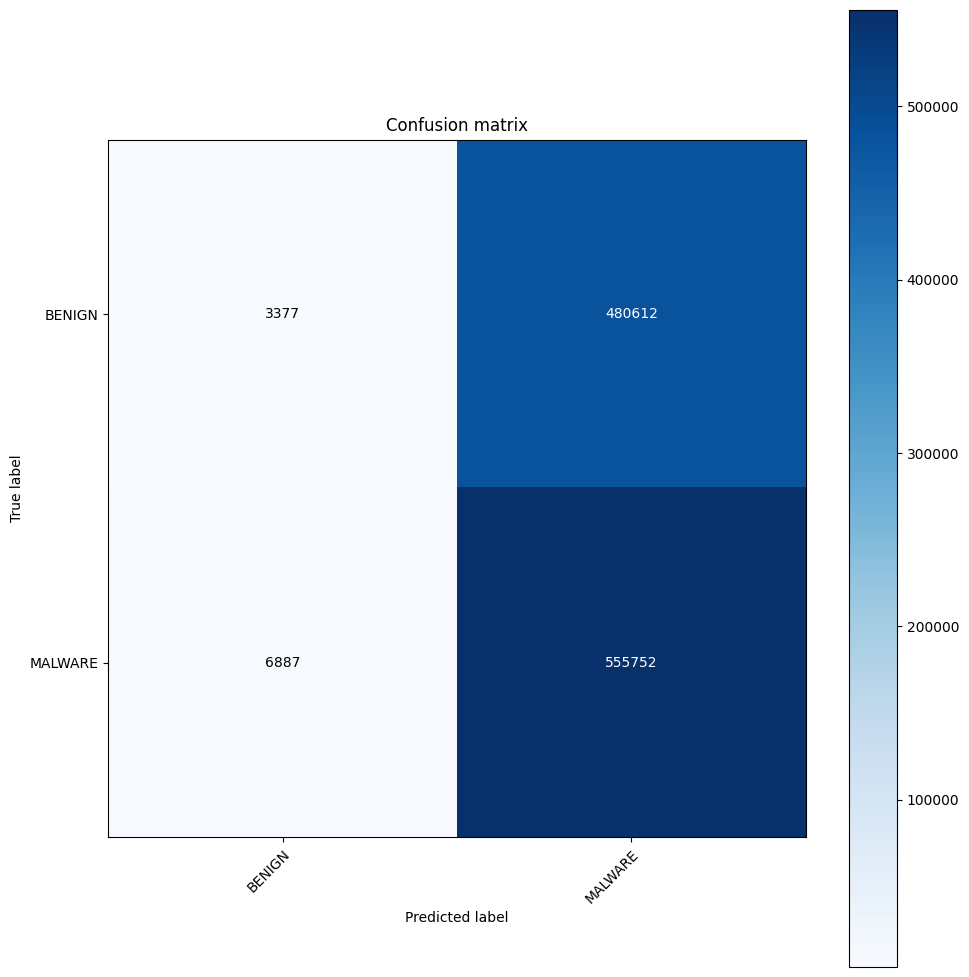

In [33]:
valuate(logistic_classifier, X_test, y_test)

# Gaussian Discriminant Analysis

In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_classifier = LinearDiscriminantAnalysis().fit(X_train, y_train)

              precision    recall  f1-score   support

      BENIGN       0.42      0.01      0.02    483989
     MALWARE       0.54      0.99      0.70    562639

    accuracy                           0.54   1046628
   macro avg       0.48      0.50      0.36   1046628
weighted avg       0.48      0.54      0.38   1046628



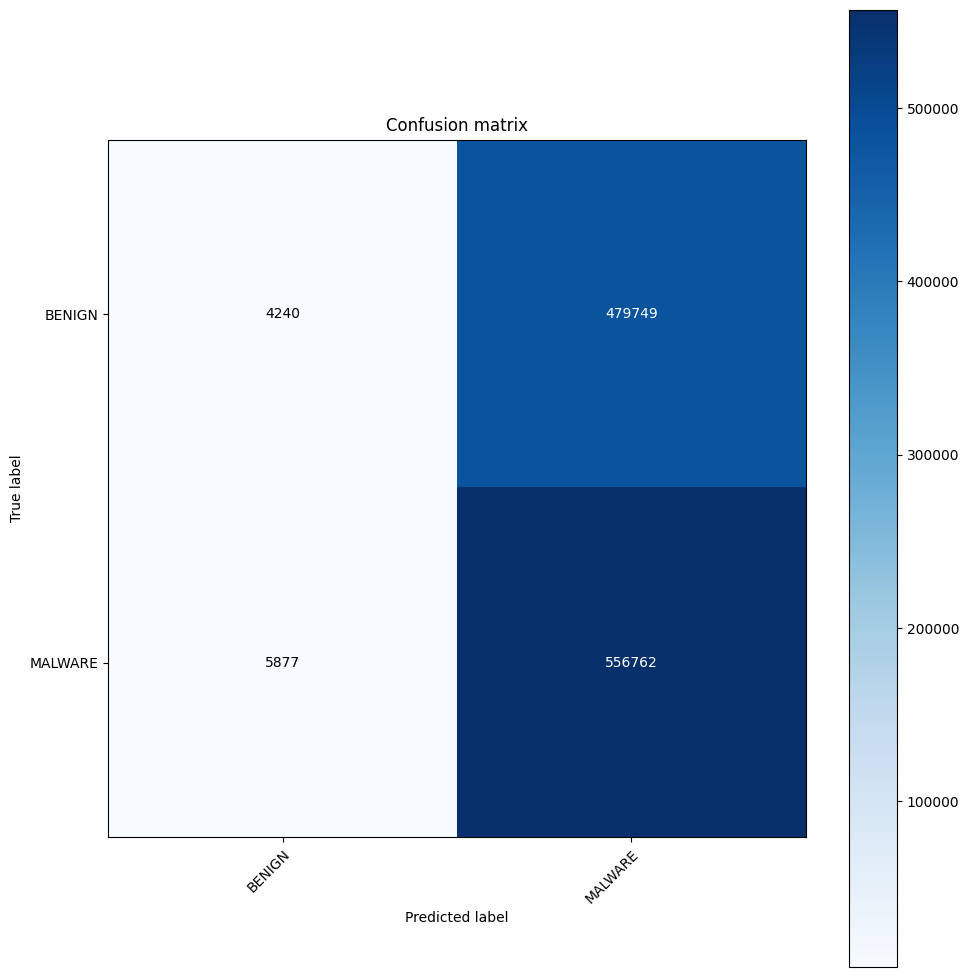

In [36]:
valuate(lda_classifier, X_test, y_test)

# MultiLayer Perceptron

In [37]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    print("Change the options of this Notebook to use the GPU instead for a quicker execution and re-run the notebook!")
    device = torch.device("cpu")

No GPU available, using the CPU instead.
Change the options of this Notebook to use the GPU instead for a quicker execution and re-run the notebook!


In [38]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(y):
    y = y.values.reshape(-1, 1)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
    y = ohe.transform(y)
    return y


X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(one_hot_encoding(y_train), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(one_hot_encoding(y_test), dtype=torch.float32)

In [39]:
from torch.utils.data import Dataset, DataLoader

class NetworkDataset(Dataset):
    def __init__(self, data, target):
        self.data = data.to_numpy()
        #self.data = data
        self.target = label_encoder.fit_transform(target)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]


train_dataset = NetworkDataset(X_train, y_train)
test_dataset = NetworkDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [40]:
import torch.nn as nn
import torch.nn.functional as F

class NetworkNN(nn.Module):

    def __init__(self):
        super(NetworkNN, self).__init__()
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 5)
        self.fc3 = nn.Linear(5, 2)
        self.logits = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.logits(x)
        return x

model = NetworkNN()

In [41]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, dataloader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1} loss: {running_loss / len(dataloader)}')

In [42]:
train(model, train_dataloader, criterion, optimizer, epochs=10)

Epoch 1 loss: 101.34392438190827
Epoch 2 loss: 0.6903742618573621
Epoch 3 loss: 0.6903768166396111
Epoch 4 loss: 0.6903798979963744
Epoch 5 loss: 0.690372081252133
Epoch 6 loss: 0.6903732041063527
Epoch 7 loss: 0.6903824038066446
Epoch 8 loss: 0.6903761389723886
Epoch 9 loss: 0.6903721644814145
Epoch 10 loss: 0.6903772702433254


In [43]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for _ in range(2))
class_total = list(0. for _ in range(2))

model.eval() # prep model for *evaluation*

for data, target in test_dataloader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.float())
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.690322

Test Accuracy of     0:  0% ( 0/483989)
Test Accuracy of     1: 100% (562639/562639)

Test Accuracy (Overall): 53% (562639/1046628)
